In [333]:
import numpy as np 
from matplotlib import pyplot as plt
import matplotlib.animation as animation



The gravitational potential for a particle is foudn by convolving the density with the Green function as $\frac{1}{4\pi r}$. This can be done in $N\log(N)$ operations using FFTs.

This process involves finding the solution of Poissons equation with the aforementioned Greens function. The convolution in real space is the mutlplication of our density witht the greens function in fourier space.
The force can then be found from the scalar potential by taking the gradient in the x and y direction thus producing force vectors.


In [255]:

def part_grid(x_par,y_par,grid_sz,n_par,mass):
    "Creating the particle mesh grid"
    grid_list=np.zeros([grid_sz, grid_sz])
    rang=np.linspace(0,grid_sz,grid_sz)
    #digitize to get the indexes of the grid
    ind=np.stack((np.digitize(x_par,rang)-1,np.digitize(y_par,rang)-1))
    #create the points on the grid at which the mass is focused by rounding the positions to the grid points
    # Adding the mass/densityu to the grid point at which the particles are situated
    for i in range(n_par):
        #assigning the particle mass to the grid points with masss
        grid_list[ind[0, i],ind[1, i]] += mass[i]
    return grid_list, ind


def get_force(x_par,y_par,grid_sz,n_par,mass,soft,bc):
    '''
    convolute the greens function with our density in order to get the potential.
    The green's function is 1/(4piR), this is computed on the grid the potential is then calculated and the force is
    taken from the gradient of the potential
    '''
    #taking our range in order to make a meshgrid for our green's func
    rang=np.linspace(0,grid_sz,grid_sz)
    X,Y=np.meshgrid(rang,rang)
    rsq = np.sqrt(X**2 + Y**2)
    # is the radius is below the softening set it to the softening radius
    rsq[rsq<soft**2]=soft**2
    #adding the softening to the radius 
    rsq+=soft**2
    green=1/(4*np.pi*np.sqrt(rsq))
    
    if grid_sz%2==0:
        #adding the flip of the green's function along both axes such that it holds in fourier space
        green+=np.flip(green,0)
        green+=np.flip(green,1)
    
    #if we use an odd grid size just don't
    else:
        print('Use even grid size!')
        exit(1)

    
    grids,ind=part_grid(x_par,y_par,grid_sz,n_par,mass)
    #calculating the potential
    pot = np.real(np.fft.ifft2(np.fft.fft2(green)*np.fft.fft2(grids)))
    #centering the potential on the particle rather than the grid point by rolling and taking the mid point
    pot = 0.5 * (np.roll(pot, 1, axis=1) + pot)
    pot = 0.5 * (np.roll(pot, 1, axis=0) + pot)
    
    if bc == 'non-per':
    # Setting the boundary conditions for the non-periodic case
    # is non-periodic at the boundaries
        pot[:, 0], pot[:, -1], pot[0, :], pot[-1, :]   = 0,0,0,0         
    #calculating the forces and centering them of the grid points
    fx, fy = np.gradient(pot)*grids
    
    return fx, fy, pot, ind

def get_evolve(x_par,y_par,vx,vy,dt,grid_sz,n_par,mass,soft,bc):
    '''
      function taking the masses acting on the grid and evolving them in time using basic dynamics equations
    '''

    # updating the x and y grid points
    # periodic bcs raking modulus of the grid size
    x_par += vx * dt
    x_par = x_par%(grid_sz-1)
    y_par += vy * dt
    y_par = y_par%(grid_sz-1)

    # get the forces and the potential 
    fx, fy, pot, ind = get_force(x_par,y_par,grid_sz,n_par,mass,soft,bc) 

    # updating the velocity with acceleration * dt
    for i in range(len(x_par)):
        vx[i] += (fx[ind[0,i], ind[1,i]] * dt)/mass[i]
        vy[i] += (fy[ind[0,i], ind[1,i]] * dt)/mass[i]

    #  kinetic energy as the sum of 0.5*m*v**2
    kin = 0.5 * np.sum(mass * (vx**2 + vy**2))
    #summing the potential
    pot = -0.5 * np.sum(pot)
    # calculating the total energy
    ene = kin + pot

  
    return x_par,y_par,vx,vy,ene

# Part 1: 

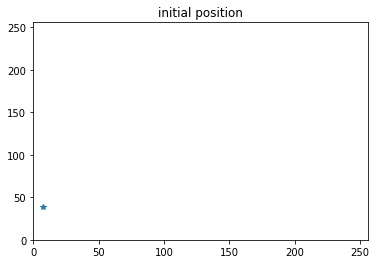

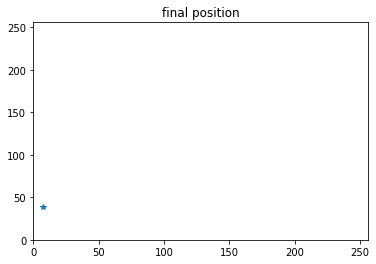

the initial x,y position is [7.25787719] , [39.15266605]
the final x,y position is [7.25787719] , [39.15266605]


<Figure size 432x288 with 0 Axes>

In [375]:
import numpy as np 
from matplotlib import pyplot as plt
import matplotlib.animation as animation
#from particle import *

#setting the initial condtions
dt=0.1
n_par = 1
mass= 1.0*np.ones(n_par)

#distributing the particle randomly
grid_size=256
x_par=(grid_size)*np.random.rand(n_par)
y_par=(grid_size)*np.random.rand(n_par)

#no initial velocity
vx = np.zeros(n_par)
vy = np.zeros(n_par)

#setting up conditions 
bc='non-per'
soft=0.01
#taking 100 time steps
n_step=500
x_pos=[]
y_pos=[]
#evolving the particle to see if it moves
for i in range(n_step):
    x_par,y_par,vx,vy,Energy=get_evolve(x_par,y_par,vx,vy,dt,grid_size,n_par,mass,soft,bc)
    x_pos.append(x_par)
    y_pos.append(y_par)
    #plt.clf()
    plt.pause(1e-1)
plt.title('initial position')
plt.plot(x_pos[-1], y_pos[-1], '*')
plt.ylim((0,grid_size))
plt.xlim((0,grid_size))
plt.show()
plt.clf()

plt.title('final position')
plt.plot(x_pos[-1], y_pos[-1], '*')
plt.ylim((0,grid_size))
plt.xlim((0,grid_size))
plt.show()
plt.clf()

print('the initial x,y position is', x_pos[0],',',y_pos[0])
print('the final x,y position is', x_pos[-1],',',y_pos[-1])

In [376]:
t = np.arange(0,nstep*dt,dt)
timestamp = ['t = {:.2f}'.format(ti) for ti in t]

fig = plt.figure()
ax = plt.axes(xlim=(0,grid_size), ylim=(0, grid_size))
scat = ax.scatter([], [])
time_text = ax.text(0.02, 0.92, '', transform=ax.transAxes)
plt.close()

def init():
    scat.set_offsets([])
    time_text.set_text('')
    return scat, time_text

def animate(i):
    scat.set_offsets(np.column_stack((x_pos[i],y_pos[i])))
    time_text.set_text(timestamp[i])
    return scat,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nstep, interval=50, blit=True)
anim.save('part1.gif')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


We can see here that the particle does not move in time. This is as expected since there are no other particles producing a potential and thus there is no force acting on the particle.

# Part 2: Orbiting Particles

In [381]:

#setting initial conditions of 2 particles in orbit
bc='non-per'
n_par = 2
mass=5*np.ones(n_par)
grid_size=400
soft=0.1
dt=10
vi=0.1
x = np.zeros(n_par)
y = 0 * x

#initial placing particles in the center of our grid and displacing them
x[0] = (grid_size/2 - 30)
x[1] = (grid_size/2 + 30)
y[0] = (grid_size/2)
y[1] = (grid_size/2)



vx = np.zeros(n_par)
vy = 0 *vx

#giving the particles an initial velocity in the y in opposite directions to create an orbit
vy[0] = vi
vy[1] = -1 * vy[0]



#plotting initial position of the particles
plt.title('initial positions')
plt.plot(y[0], x[0],'.' color='blue')
plt.plot(y[1], x[1],'.' color='red')
plt.ylim((0,grid_size))
plt.xlim((0,grid_size))
plt.pause(0.1)
plt.show()

nstep=500
x1_pos=np.zeros([nstep,n_par])
y1_pos=np.zeros([nstep,n_par])
#evolving it in time
for i in range(nstep):
    x1_pos[i]=x
    y1_pos[i]=y
    x,y,vx,vy,Energy=get_evolve(x,y,vx,vy,dt,grid_size,n_par,mass,soft,bc)
    #plt.clf()

    
    #plt.plot(y[0], x[0], '*', color='blue')
    #plt.plot(y[1], x[1], '*', color='red')
    #plt.ylim((0,grid_size))
    #plt.xlim((0,grid_size))
        # plt.pcolormesh(part.grid)
        # plt.colorbar()
    plt.pause(1e-2)
f, ax = plt.subplots()
ax.set_title('Orbital path of 2 particles')
#ax.set_aspect('equal')
#colours = ['C0', 'C1']
for i in range(n_par):
    plt.plot(x1_pos[:,i], y1_pos[:,i])
    plt.plot(x1_pos[-1,i], y1_pos[-1,i], 'o')
ax.set_xlim(0,grid_size)
ax.set_ylim(0,grid_size)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(['particle 1 orbit', 'particle 1', 'particle 2 orbit', 'particle 2'])
plt.show()

SyntaxError: invalid syntax (<ipython-input-381-999b17084052>, line 31)

In [298]:
t = np.arange(0,nstep*dt,dt)
tstp = ['t={:.1f}'.format(i) for i in t]

fig = plt.figure()
ax = plt.axes(xlim=(0,grid_size), ylim=(0, grid_size))

dat1, = ax.plot([], [])
dat2, = ax.plot([], [])
scatter = ax.scatter(x1_pos[0,:] , y1_pos[0,:])
time_text = ax.text(0.02, 0.92, '', transform=ax.transAxes)
plt.close()

def animation(j):
    dat1.set_data(x1_pos[:j+1,0], y1_pos[:j+1,0])
    dat2.set_data(x1_pos[:j+1,1], y1_pos[:j+1,1])
    scatter.set_offsets(np.column_stack((x1_pos[j,:],y1_pos[j,:])))
    time_text.set_text(tstp[j])
    return scatter,

# Save the animation in .mp4 format.
anim = ani.FuncAnimation(fig, animation, frames=nstep, interval=20)
anim.save('Part2.gif')


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


We see here that the two particles remain in orbit when placed in an initial orbit as they are constrained by their potentials. There is no external potential removing them from the orbit 

# Part 3A: Periodic Boundary Conditions

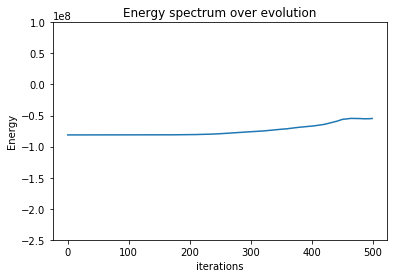

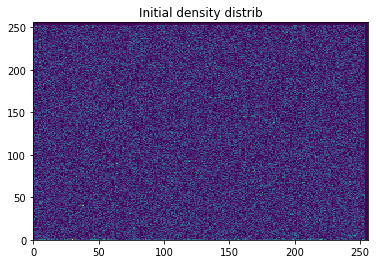

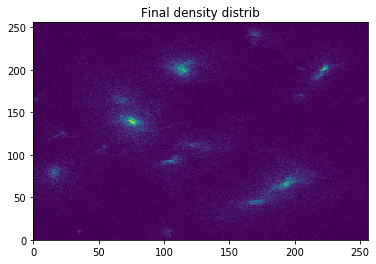

In [382]:




#setting the initial conditions using periodic boundary conditions for the potential
bc='periodic'
soft = 1
n_par=100000

grid_size = 256
#initializing the system
dt=0.05
#setting all masses
mass=np.ones(n_par)

#randomly distributing particles, no initial velocity
x = (grid_size) * np.random.rand(n_par)
y = (grid_size) * np.random.rand(n_par)
vx = np.zeros(n_par)
vy = 0 *vx

Ener=[]
densi=[]
nstep=500
for i in range(nstep):
    x,y,vx,vy,Energy=get_evolve(x,y,vx,vy,dt,grid_size,n_par,mass,soft,bc)
    #plt.clf()
    Ener.append(Energy)
    #print(Energy)
    grids,_=part_grid(x,y,grid_size,n_par,mass)
    densi.append(grids)
    #plt.pcolormesh(grids)
    plt.pause(1e-2)
#plt.ylim(0.8e8,1e8)

#plotting the energy spectrum over the evolutions and the density maps at the start and end
plt.title('Energy spectrum over evolution')
plt.xlabel('iterations')
plt.ylabel('Energy')
plt.ylim(-2.5e8,1e8)
plt.plot(Ener)
plt.show()
plt.clf()
plt.title('Initial density distrib')
plt.pcolormesh(densi[0])
plt.show()
plt.clf()
plt.title('Final density distrib')
plt.pcolormesh(densi[-1])
plt.show()


In [ ]:
#animating

t = np.arange(0,nstep*dt,dt)
tstp = ['t = {:.1f}'.format(j) for j in t]

fig = plt.figure()
ax = plt.axes(xlim=(0,grid_size), ylim=(0, grid_size))
img = ax.imshow(densi[0], origin='lower', vmax=20)
f.colorbar(img, extend='max')
t_txt = ax.text(0.05, 0.95, '', transform=ax.transAxes)
plt.close()

def animate(i):
    img.set_data(densi[i])
    t_txt.set_text(tstp[i])
    return img, t_txt

anim = animation.FuncAnimation(fig, animate, frames=nstep, interval=20)
anim.save('part3A.gif')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


We can see that for periodic boundary conditions then energy remains relatively constant staying around $-1\times 10^{8}$ to approximately $-0.5\times 10^{8}$. Therefore the energy is conserved quite well and varies by less than an order of magnitude for periodic boundary conditions. We can see clusters of particles begin to form as the evolution progresses.

# Part 3b) Non-periodic BCs

For periodic boundary conditions I set the boundary conditions such that the potential at the walls of the grid is 0 and the initial positions of the particles are padded such that they are not at the edge of the grid. Particles that exit the grid are then destroyed so they do not impact the energy of the system.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diff

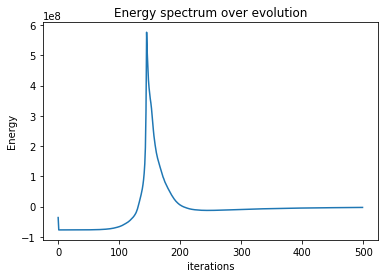

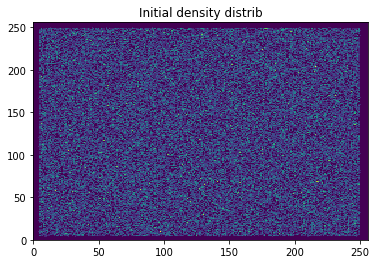

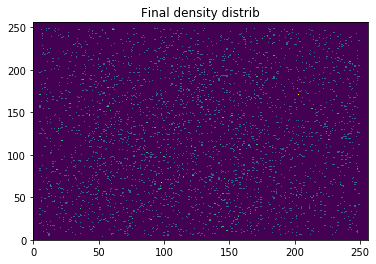

<Figure size 432x288 with 0 Axes>

In [364]:
 
#setting non-periodic boundary conditions and eliminating the particles that exit our grid


bc='non-per'
soft = 1

n_par=100000
    # size of our particle mesh
grid_size = 256
#initializing our system
dt=0.05
mass=(1)*np.ones(n_par)
pad=5
#padding the initial particle distribution so particles don't immediately exit the grid 
x = (grid_size - pad) * np.random.rand(n_par) + pad
y = (grid_size - pad) * np.random.rand(n_par) + pad
vx = np.zeros(n_par)
vy = 0 *vx

Ener=[]
densi=[]
for i in range(500):
    x,y,vx,vy,Energy=get_evolve(x,y,vx,vy,dt,grid_size,n_par,mass,soft,bc)
    #finding the indexs of particles that remain within our grid
    id_stay = [(x >= pad)&(x < grid_size-pad)&(y >= pad)&(y < grid_size-pad)]
    
    #keeping only the particles that remain within our grid for the energy
    x = x[id_stay]
    y = y[id_stay]
    vx = vx[id_stay]
    vy = vy[id_stay]
    
    n_par=len(x)
    mass=1*np.ones(n_par)
    plt.clf()
    grids,_=part_grid(x,y,grid_size,n_par,mass)
    #plt.pcolormesh(grids)
    #plt.show()
    Ener.append(Energy)
    densi.append(grids)
    
#plt.ylim(-1e21,1e21)

#plotting the energy spectrum and the inital and final densities
plt.title('Energy spectrum over evolution')
plt.xlabel('iterations')
plt.ylabel('Energy')
plt.plot(Ener)        
plt.show()
plt.clf()
plt.title('Initial density distrib')
plt.pcolormesh(densi[0])
plt.show()
plt.clf()
plt.title('Final density distrib')
plt.pcolormesh(densi[-1])
plt.show()
plt.clf()
    #plt.pause(1e-2)

In [368]:
# Animate it!
t = np.arange(0,nstep*dt,dt)
tstp = ['t = {:.1f}'.format(j) for j in t]

fig = plt.figure()
ax = plt.axes(xlim=(0,grid_size), ylim=(0, grid_size))
img = ax.imshow(densi[0], origin='lower',  vmax=5)
f.colorbar(img)
t_txt = ax.text(0.05, 0.95, '', transform=ax.transAxes)
plt.close()

def anim(i):
    img.set_data(densi[i])
    t_txt.set_text(tstp[i])
    return img, t_txt

anim = animation.FuncAnimation(fig, anim, frames=nstep, interval=50)
anim.save('Part3B.gif')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


We can see that energy is not conserved for the non-periodic system. It appears as though the energy undergoes a sharp increase as the particles gather to the center and then spread out at high speeds. As particles begin to exit the grid and their energy is ignored the energy of the system starts to decrease again, until finally there is a smaller clump of particles in the distribution with a relatively constant energy. The energy goes from around $-1\times 10^{8}$ to $5\times 10^{8}$ and is therefore not conserved.

# Part 4: $k^{-3}$ Mass Fluctuations

To generate mass fluctuations of the order $k^{-3}$ I fourier transform the initial density and compute the third power in fourier space. Then multiplying this by random gausssian noises and adding it to our fourier density. I then take the inverse fourier trasnform and compute the ratio of this density to the initial one in order to normalize that values at the grid points. From this we have a new array of masses at the same position as before and thus have a density distribution with masses fluctuation around $k^{-3}$

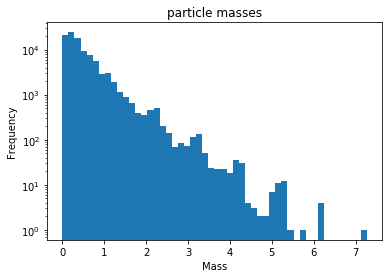

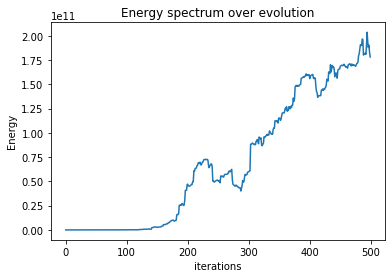

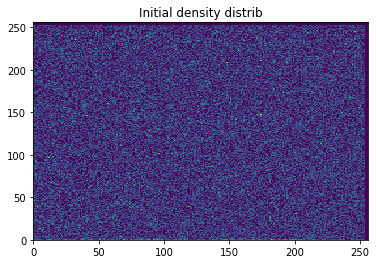

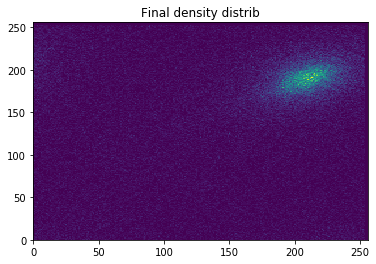

In [377]:
   

# Assigning particles mass based on a power law distribution
# k^(-3)
bc='periodic'
soft = 2.0
n_par=100000
grid_size = 256
dt=0.1

x = (grid_size) * np.random.rand(n_par)
y = (grid_size) * np.random.rand(n_par)
vx = np.zeros(n_par)
vy = 0 *vx

# initialize the system
mass=np.ones(n_par)



#setting tolerance to avoid 0 values in fourier space.
#tol = 1e-4
dens,ind=part_grid(x,y,grid_size,n_par,mass)

dens_FT = np.fft.fft2(dens)
# Replace all k modes smaller than tolerance by 1.0
#dens_FT[dens_FT < tol] = 1.0
# calculating a random gaussian noise in k space with 1/k^3
k_noise = np.random.randn(dens_FT.shape[0], dens_FT.shape[1])/np.abs(dens_FT**3)
#calculating the noise density with our gaussian distrib of masses around 1/k*3
#using a proportionality constant of 1
#shifting the noise density and taking it in real space
noise_dens = np.fft.fftshift(np.abs(np.fft.irfft2(dens_FT+1*k_noise)))
#taking the ratio of the new density with our original in order distribute the mass and
#normalize it to reasonable values in order to get the new mass for the particles
ratio_density = noise_dens[ind[0,:],ind[1,:]]/dens[ind[0,:],ind[1,:]]
#normalizing our mass with the number of particles in the system
mass_new = ratio_density
#print(mass_new)

plt.title('particle masses')
plt.hist(mass_new, 50, log=True)
plt.xlabel('Mass')
plt.ylabel('Frequency')
plt.show()



    # To plot in real time -------------------------------------------------------------

    # evolve it in time
E=[]
dens=[]
nstep=500
for i in range(nstep):
    x,y,vx,vy,Energy=get_evolve(x,y,vx,vy,dt,grid_size,n_par,mass_new,soft,bc)
    E.append(Energy)
    grids,_=grid(x,y,grid_size,n_par,mass)
    dens.append(grids)
    #plt.clf()
    #plt.pcolormesh(grids)
    #plt.show()
    
        #plt.colorbar()

    #plt.pause(1e-1)
plt.title('Energy spectrum over evolution')
plt.xlabel('iterations')
plt.ylabel('Energy')
plt.plot(E)
plt.show()
plt.clf()
plt.title('Initial density distrib')
plt.pcolormesh(dens[0])
plt.show()
plt.clf()
plt.title('Final density distrib')
plt.pcolormesh(dens[-1])
plt.show()




   





In [378]:

t = np.arange(0,nstep*dt,dt)
tstp = ['t = {:.1f}'.format(j) for j in t]

fig = plt.figure()
ax = plt.axes(xlim=(0,grid_size), ylim=(0, grid_size))
img = ax.imshow(dens[0], origin='lower', vmax=5)
f.colorbar(img, extend='max')
t_txt = ax.text(0.05, 0.95, '', transform=ax.transAxes)
plt.close()

def animate(i):
    img.set_data(dens[i])
    t_txt.set_text(tstp[i])
    return img, t_txt

anim = animation.FuncAnimation(fig, animate, frames=nstep, interval=20)
anim.save('Part4.gif')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


The particles don't converge as quickly here as they did for the previous periodic potential as there is a wider distribution of masses and thus less uniformity in the potential and density. The universe appears to go from a random distribution of particles into more ordered strings of particles which then converge into clusters. The clusters of particles connect in blobs of particles which appear less evenly distributed and less periodic than the periodic simulation earlier.